In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsIC
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# Data preparation

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

weather_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/weather_features.csv')
energy_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/energy_dataset.csv')

Mounted at /content/gdrive/


In [3]:
weather_data['city_name'].unique()
weather_data_valencia = weather_data[weather_data['city_name'] == 'Valencia']

valencia_df = pd.concat([energy_data, weather_data_valencia], axis=1, join="inner")
valencia_df.to_csv('valencia_df.csv', index=False)
valencia_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)
valencia_df = valencia_df.drop(['city_name','generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 
                            'forecast wind offshore eday ahead',
                            'total load forecast', 
                            'forecast solar day ahead',
                            'forecast wind onshore day ahead',
                            'weather_id', 'clouds_all', 
                            'time', 'wind_deg',
                            'rain_1h', 'rain_3h', 'snow_3h'], 
                            axis=1)

valencia_df = valencia_df[['total load actual', 'weather_main', 
                           'generation hydro pumped storage consumption', 
                           'generation fossil gas', 'generation fossil oil', 
                           'price day ahead', 'generation hydro water reservoir', 
                           'price actual']]

In [4]:
subsample = ['generation hydro pumped storage consumption', 
             'generation fossil gas', 'generation fossil oil', 
             'price day ahead', 'generation hydro water reservoir', 
             'price actual']


subsampleX = valencia_df[['weather_main', 'generation hydro pumped storage consumption', 
                          'generation fossil gas', 'generation fossil oil', 'price day ahead', 
                          'generation hydro water reservoir', 'price actual']]

target = valencia_df['total load actual']

## Step 1: Non-parametric estimation of PDF in form of histogram and using kernel density function for MRV.

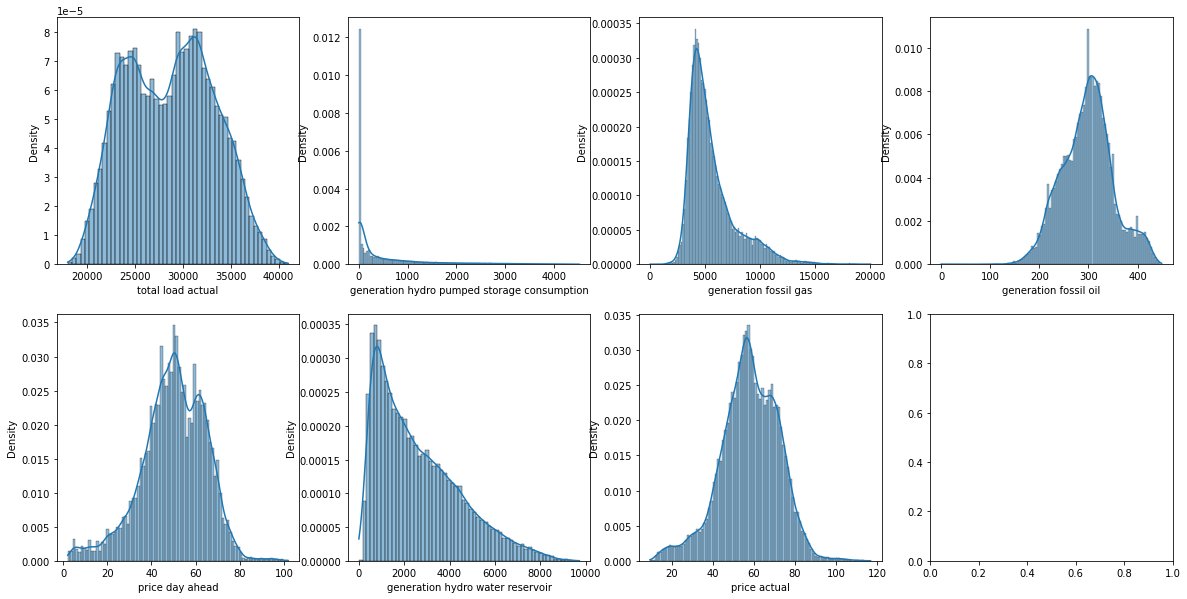

In [5]:
figure, ax = plt.subplots(2, 4, figsize=(20, 10))

tla = sns.histplot(valencia_df['total load actual'], ax=ax[0, 0], kde=True, stat='density')
tla.set(xlabel='total load actual')

ghpsc = sns.histplot(valencia_df['generation hydro pumped storage consumption'], ax=ax[0, 1], kde=True, stat='density')
ghpsc.set(xlabel='generation hydro pumped storage consumption')

gfg = sns.histplot(valencia_df['generation fossil gas'], ax=ax[0, 2], kde=True, stat='density')
gfg.set(xlabel='generation fossil gas')

gfo = sns.histplot(valencia_df['generation fossil oil'], ax=ax[0, 3], kde=True, stat='density')
gfo.set(xlabel='generation fossil oil')

pda = sns.histplot(valencia_df['price day ahead'], ax=ax[1, 0], kde=True, stat='density')
pda.set(xlabel='price day ahead')

ghwr = sns.histplot(valencia_df['generation hydro water reservoir'], ax=ax[1, 1], kde=True, stat='density')
ghwr.set(xlabel='generation hydro water reservoir')

pa = sns.histplot(valencia_df['price actual'], ax=ax[1, 2], kde=True, stat='density')
pa.set(xlabel='price actual')

plt.show()

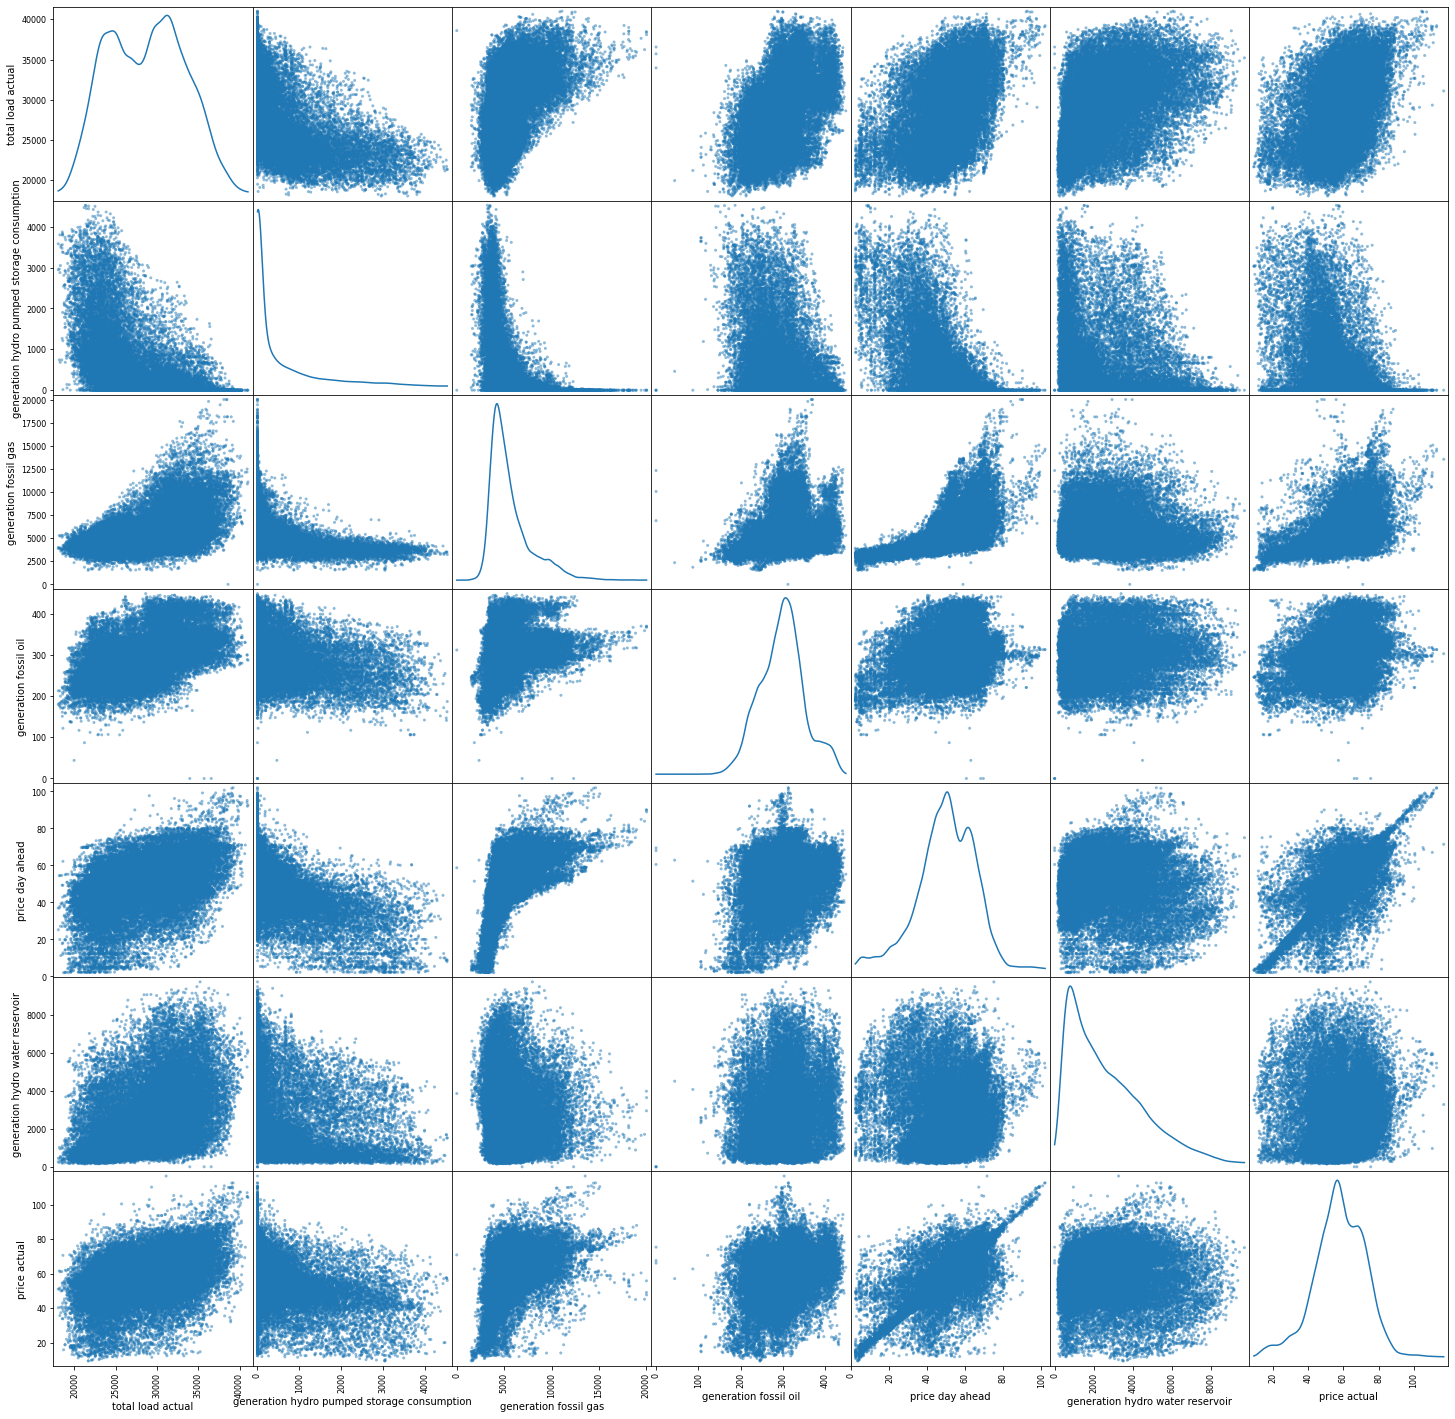

In [6]:
pd.plotting.scatter_matrix(valencia_df,  diagonal='kde', figsize=(25,25))
plt.show()

## Step 2: Estimation of multivariate mathematical expectation and variance.

In [7]:
subsampleX[subsample].mean()

generation hydro pumped storage consumption     475.582706
generation fossil gas                          5622.700647
generation fossil oil                           298.342417
price day ahead                                  49.874341
generation hydro water reservoir               2605.534123
price actual                                     57.884023
dtype: float64

In [8]:
subsampleX[subsample].cov()
#Maybe it's not required

,generation hydro pumped storage consumption,generation fossil gas,generation fossil oil,price day ahead,generation hydro water reservoir,price actual
generation hydro pumped storage consumption,627759.421085,-7.339115e+05,-13771.537963,-6956.287938,-3.408954e+05,-4796.437549
generation fossil gas,-733911.467142,4.846651e+06,35789.746612,20626.723068,2.438011e+05,14429.805831
generation fossil oil,-13771.537963,3.578975e+04,2758.342733,224.828751,1.549294e+04,212.646511
price day ahead,-6956.287938,2.062672e+04,224.828751,213.712228,-4.658882e+02,152.030664
generation hydro water reservoir,-340895.376509,2.438011e+05,15492.937712,-465.888173,3.367868e+06,1874.464360
price actual,-4796.437549,1.442981e+04,212.646511,152.030664,1.874464e+03,201.755982


In [9]:
subsampleX[subsample].var()

generation hydro pumped storage consumption    6.277594e+05
generation fossil gas                          4.846651e+06
generation fossil oil                          2.758343e+03
price day ahead                                2.137122e+02
generation hydro water reservoir               3.367868e+06
price actual                                   2.017560e+02
dtype: float64

## Step 3: Non-parametric estimation of conditional distributions, mathematical expectations and variances.



<Figure size 1800x1800 with 0 Axes>

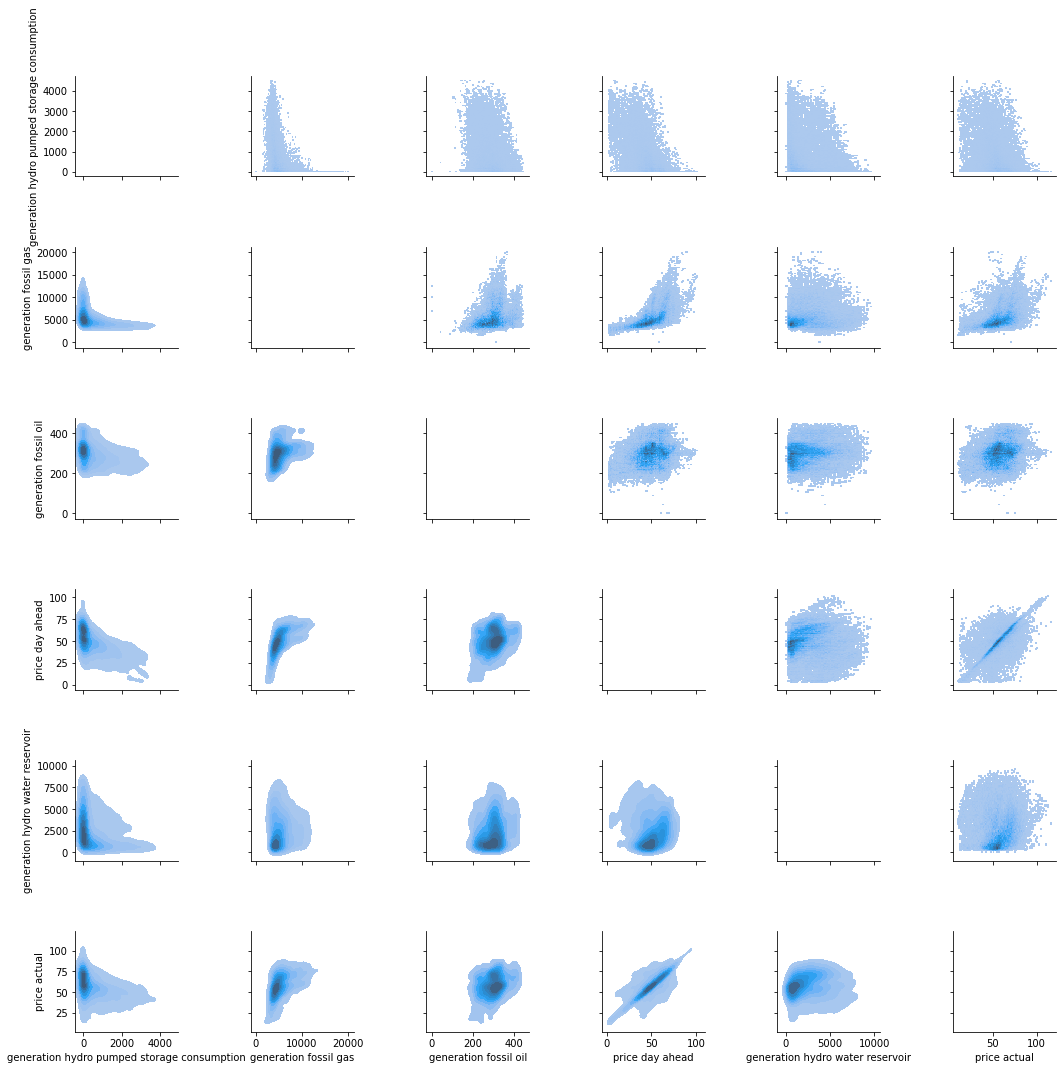

In [10]:
fig = plt.figure(figsize=(25, 25))
g = sns.PairGrid(subsampleX, vars=subsample)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)

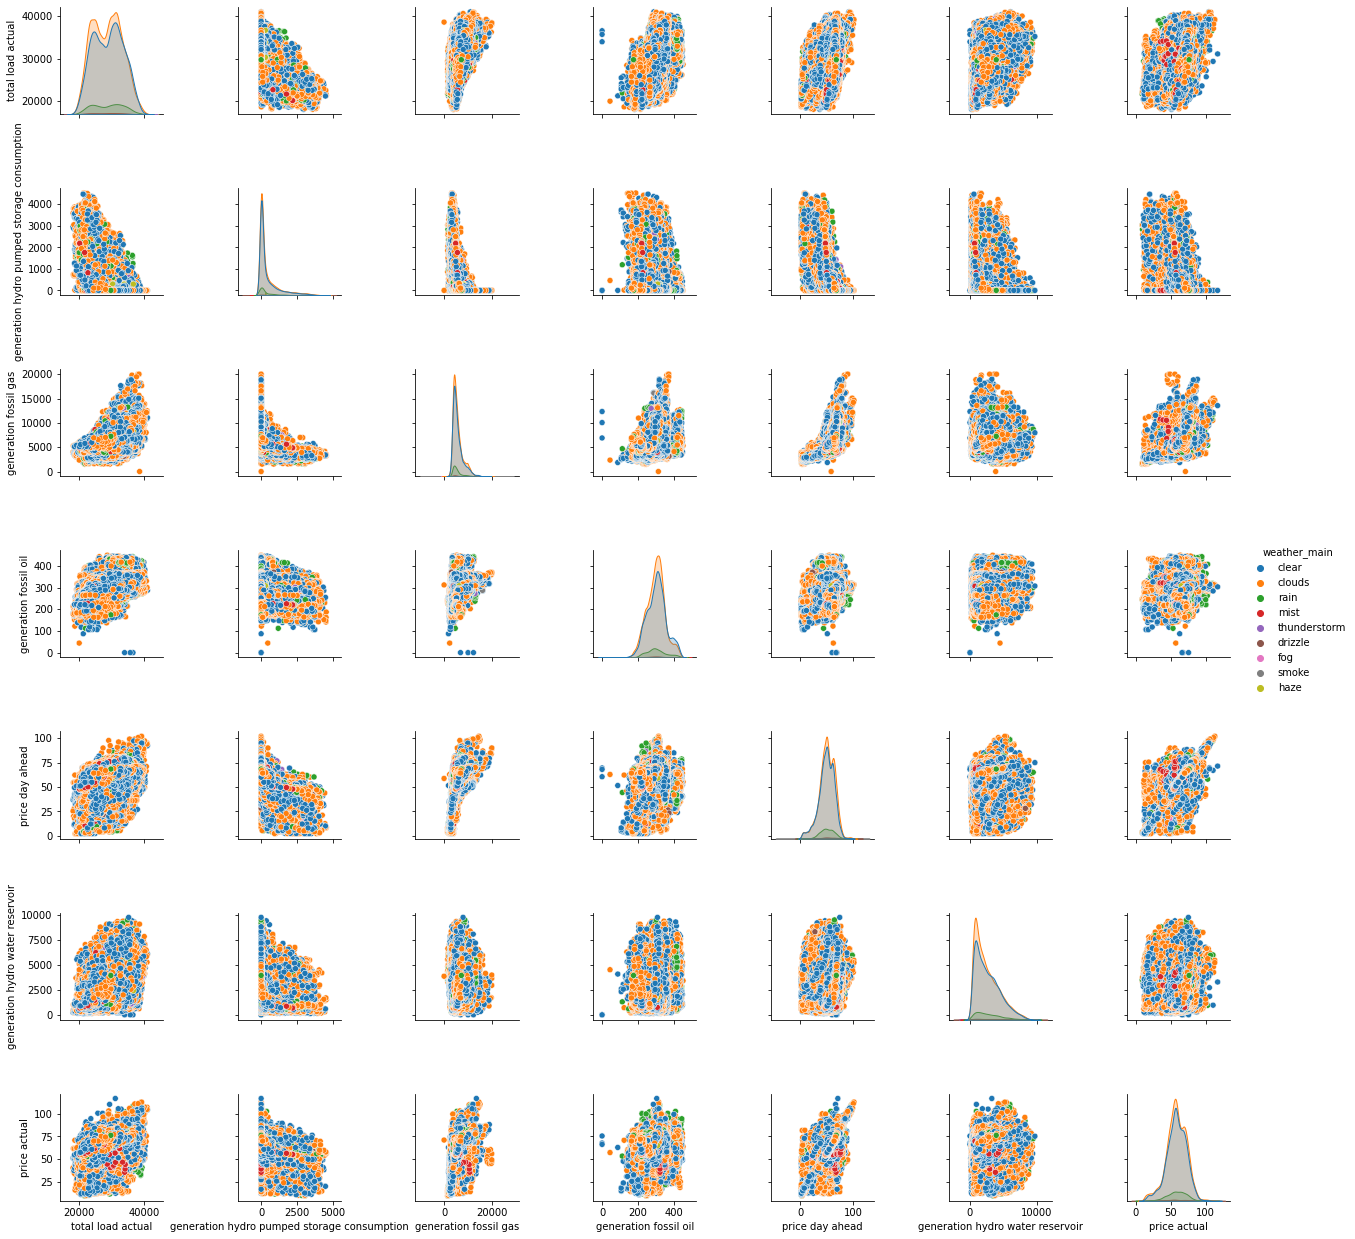

In [11]:

sns.pairplot(valencia_df[['weather_main', 'total load actual',  
                           'generation hydro pumped storage consumption', 
                           'generation fossil gas', 'generation fossil oil', 
                           'price day ahead', 'generation hydro water reservoir', 
                           'price actual']], hue='weather_main', kind='scatter')

plt.show()

In [12]:
valencia_df_cond = valencia_df[subsampleX['weather_main'] == 'clear']
valencia_df_cond

,total load actual,weather_main,generation hydro pumped storage consumption,generation fossil gas,generation fossil oil,price day ahead,generation hydro water reservoir,price actual
0,25385.0,clear,863.0,4844.0,162.0,50.10,1899.0,65.41
1,24382.0,clear,920.0,5196.0,158.0,48.10,1658.0,64.92
2,22734.0,clear,1164.0,4857.0,157.0,47.33,1371.0,64.48
3,21286.0,clear,1503.0,4314.0,160.0,42.27,779.0,59.32
4,20264.0,clear,1826.0,4130.0,156.0,38.41,720.0,56.04
...,...,...,...,...,...,...,...,...
35044,20006.0,clear,708.0,5116.0,214.0,50.89,909.0,57.04
35045,20366.0,clear,707.0,5551.0,221.0,51.10,887.0,57.48
35046,21723.0,clear,487.0,5783.0,221.0,54.77,1203.0,61.13
35047,23850.0,clear,187.0,6002.0,217.0,54.87,1480.0,60.70


In [13]:
subsampleX.loc[subsampleX['weather_main'] == 'clear', subsample].mean()

generation hydro pumped storage consumption     464.773875
generation fossil gas                          5622.519016
generation fossil oil                           300.506296
price day ahead                                  49.164267
generation hydro water reservoir               2657.218635
price actual                                     57.832534
dtype: float64

In [14]:
subsampleX.loc[subsampleX['weather_main'] == 'clear', subsample].var()


generation hydro pumped storage consumption    6.047883e+05
generation fossil gas                          5.071875e+06
generation fossil oil                          2.929792e+03
price day ahead                                2.104686e+02
generation hydro water reservoir               3.338205e+06
price actual                                   1.927872e+02
dtype: float64

In [15]:

subsampleX.loc[subsampleX['weather_main'] == 'clear', subsample].cov()

,generation hydro pumped storage consumption,generation fossil gas,generation fossil oil,price day ahead,generation hydro water reservoir,price actual
generation hydro pumped storage consumption,604788.286902,-7.280269e+05,-14478.772441,-6929.737681,-3.246827e+05,-4638.212571
generation fossil gas,-728026.853719,5.071875e+06,38527.989588,20863.287723,1.370730e+05,14131.077547
generation fossil oil,-14478.772441,3.852799e+04,2929.791641,254.937503,1.560377e+04,219.975646
price day ahead,-6929.737681,2.086329e+04,254.937503,210.468631,-5.985031e+02,144.975510
generation hydro water reservoir,-324682.727490,1.370730e+05,15603.772481,-598.503134,3.338205e+06,1626.942688
price actual,-4638.212571,1.413108e+04,219.975646,144.975510,1.626943e+03,192.787189


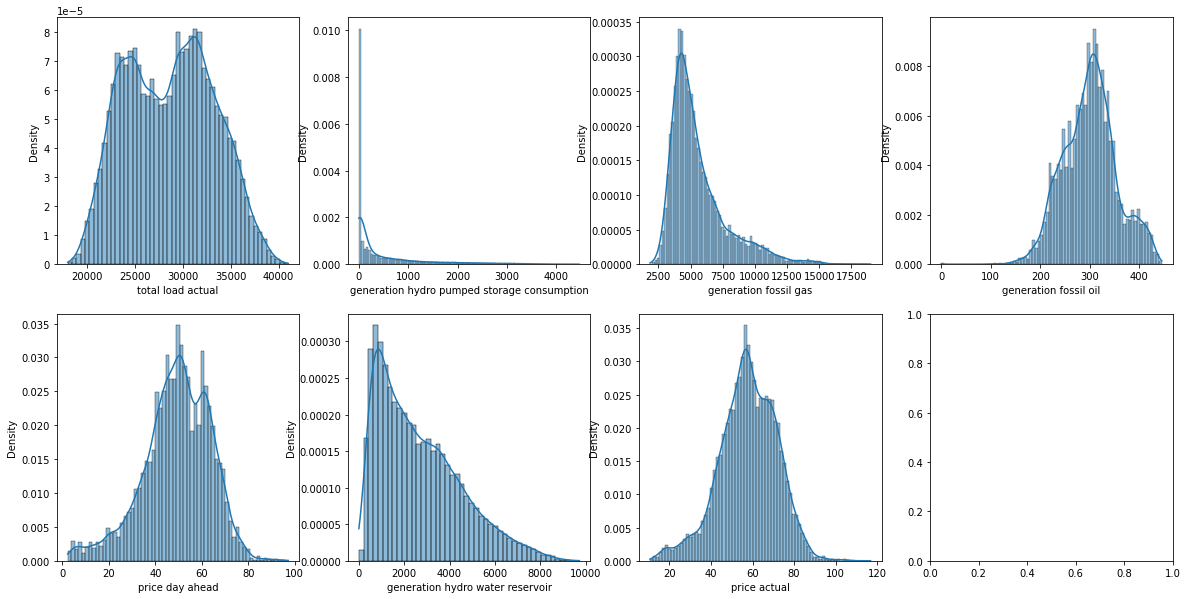

In [16]:
figure, ax = plt.subplots(2, 4, figsize=(20, 10))

tla_cond = sns.histplot(valencia_df['total load actual'], ax=ax[0, 0], kde=True, stat='density')
tla_cond.set(xlabel='total load actual')

ghpsc_cond = sns.histplot(valencia_df_cond['generation hydro pumped storage consumption'], ax=ax[0, 1], kde=True, stat='density')
ghpsc_cond.set(xlabel='generation hydro pumped storage consumption')

gfg_cond = sns.histplot(valencia_df_cond['generation fossil gas'], ax=ax[0, 2], kde=True, stat='density')
gfg_cond.set(xlabel='generation fossil gas')

gfo_cond = sns.histplot(valencia_df_cond['generation fossil oil'], ax=ax[0, 3], kde=True, stat='density')
gfo_cond.set(xlabel='generation fossil oil')

pda_cond = sns.histplot(valencia_df_cond['price day ahead'], ax=ax[1, 0], kde=True, stat='density')
pda_cond.set(xlabel='price day ahead')

ghwr_cond = sns.histplot(valencia_df_cond['generation hydro water reservoir'], ax=ax[1, 1], kde=True, stat='density')
ghwr_cond.set(xlabel='generation hydro water reservoir')

pa_cond = sns.histplot(valencia_df_cond['price actual'], ax=ax[1, 2], kde=True, stat='density')
pa_cond.set(xlabel='price actual')

plt.show()

In [17]:
valencia_df_cond = valencia_df[subsampleX['weather_main'] == 'clouds']
valencia_df_cond

,total load actual,weather_main,generation hydro pumped storage consumption,generation fossil gas,generation fossil oil,price day ahead,generation hydro water reservoir,price actual
53,21316.0,clouds,2953.0,3626.0,189.0,17.22,2449.0,56.22
54,21674.0,clouds,2744.0,3556.0,188.0,20.14,2620.0,58.13
55,22127.0,clouds,2279.0,3524.0,190.0,19.87,2559.0,62.06
139,30147.0,clouds,0.0,4553.0,351.0,57.00,3119.0,81.18
140,30120.0,clouds,0.0,4490.0,365.0,57.00,3009.0,81.65
...,...,...,...,...,...,...,...,...
35058,29592.0,clouds,1.0,7593.0,178.0,68.58,4005.0,77.61
35059,30653.0,clouds,1.0,7634.0,178.0,68.85,4836.0,77.02
35061,28071.0,clouds,50.0,7025.0,168.0,66.88,2831.0,74.30
35062,25801.0,clouds,108.0,6562.0,163.0,63.93,2068.0,69.89


In [18]:
subsampleX.loc[subsampleX['weather_main'] == 'clouds', subsample].mean()

generation hydro pumped storage consumption     487.985395
generation fossil gas                          5635.217447
generation fossil oil                           296.235583
price day ahead                                  50.323888
generation hydro water reservoir               2541.825463
price actual                                     57.798166
dtype: float64

In [19]:
subsampleX.loc[subsampleX['weather_main'] == 'clouds', subsample].var()

generation hydro pumped storage consumption    6.563920e+05
generation fossil gas                          4.689053e+06
generation fossil oil                          2.546612e+03
price day ahead                                2.184875e+02
generation hydro water reservoir               3.385006e+06
price actual                                   2.095662e+02
dtype: float64

In [20]:
subsampleX.loc[subsampleX['weather_main'] == 'clouds', subsample].cov()

,generation hydro pumped storage consumption,generation fossil gas,generation fossil oil,price day ahead,generation hydro water reservoir,price actual
generation hydro pumped storage consumption,656392.041901,-7.492851e+05,-13432.147278,-7163.560962,-3.357880e+05,-5029.008087
generation fossil gas,-749285.109783,4.689053e+06,35100.527577,20434.552005,2.679482e+05,14504.480369
generation fossil oil,-13432.147278,3.510053e+04,2546.611684,212.227166,1.452985e+04,209.408554
price day ahead,-7163.560962,2.043455e+04,212.227166,218.487460,-6.296574e+02,158.423258
generation hydro water reservoir,-335788.028023,2.679482e+05,14529.846830,-629.657434,3.385006e+06,1761.783076
price actual,-5029.008087,1.450448e+04,209.408554,158.423258,1.761783e+03,209.566240


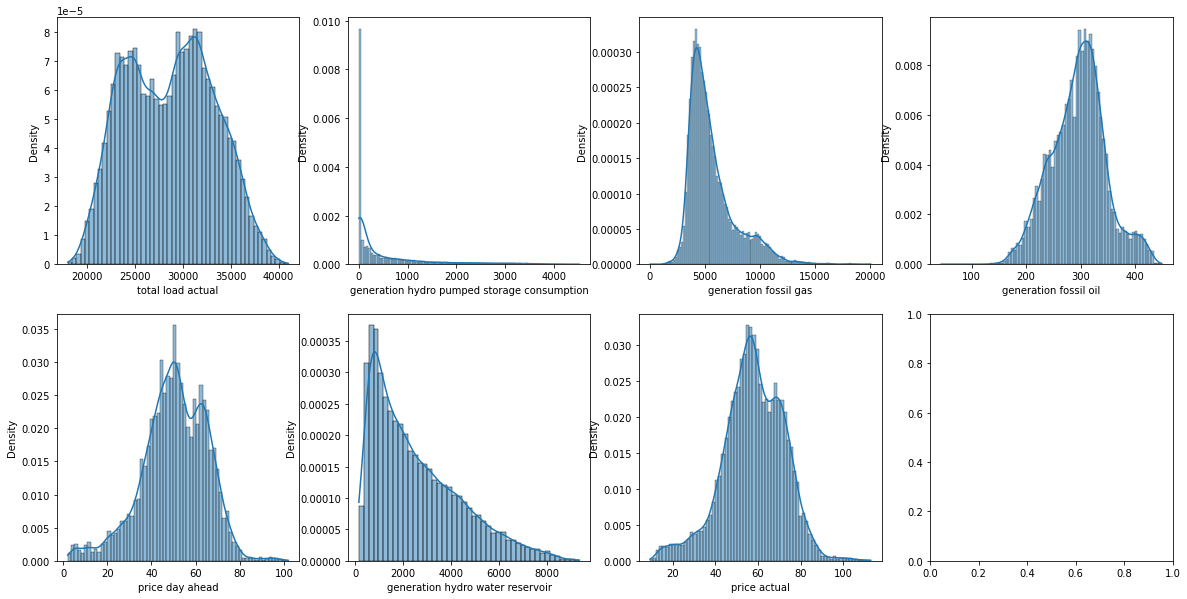

In [21]:
figure, ax = plt.subplots(2, 4, figsize=(20, 10))

tla_cond = sns.histplot(valencia_df['total load actual'], ax=ax[0, 0], kde=True, stat='density')
tla_cond.set(xlabel='total load actual')

ghpsc_cond = sns.histplot(valencia_df_cond['generation hydro pumped storage consumption'], ax=ax[0, 1], kde=True, stat='density')
ghpsc_cond.set(xlabel='generation hydro pumped storage consumption')

gfg_cond = sns.histplot(valencia_df_cond['generation fossil gas'], ax=ax[0, 2], kde=True, stat='density')
gfg_cond.set(xlabel='generation fossil gas')

gfo_cond = sns.histplot(valencia_df_cond['generation fossil oil'], ax=ax[0, 3], kde=True, stat='density')
gfo_cond.set(xlabel='generation fossil oil')

pda_cond = sns.histplot(valencia_df_cond['price day ahead'], ax=ax[1, 0], kde=True, stat='density')
pda_cond.set(xlabel='price day ahead')

ghwr_cond = sns.histplot(valencia_df_cond['generation hydro water reservoir'], ax=ax[1, 1], kde=True, stat='density')
ghwr_cond.set(xlabel='generation hydro water reservoir')

pa_cond = sns.histplot(valencia_df_cond['price actual'], ax=ax[1, 2], kde=True, stat='density')
pa_cond.set(xlabel='price actual')

plt.show()

## Step 4: Estimation of pair correlation coefficients, confidence intervals for them and significance levels.

In [22]:
def get_corr(x, y):
  r, p = stats.pearsonr(x, y) # p : p-value r: correlation coefficient

  r_z = np.arctanh(r)
  se = 1/np.sqrt(x.size-3)
  alpha = 0.05
  z = stats.norm.ppf(1-alpha/2)
  low_z, high_z = r_z - z * se, r_z + z * se
  low, high = np.tanh((low_z, high_z))
  return 'Confidence Interval: ({:.4f}, {:.4f})'.format(low_z, high_z), 'Significance Level: {:}'.format(p), 'Correlation Coefficient: {:.4f}'.format(r)

In [23]:
df_CI = pd.DataFrame(columns=subsample, index=subsample) # confidence intervals
df_SL = pd.DataFrame(columns=subsample, index=subsample) # significance level
df_CC = pd.DataFrame(columns=subsample, index=subsample) # correlation coefficient

In [24]:
for i in subsample:
  for j in subsample:
    df_CI.loc[i,j] = get_corr(subsampleX[i],subsampleX[j])[0]
    df_SL.loc[i,j] = get_corr(subsampleX[i],subsampleX[j])[1]
    df_CC.loc[i,j] = get_corr(subsampleX[i],subsampleX[j])[2]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in arctanh
  after removing the cwd from sys.path.


In [25]:
df_CI.head()

,generation hydro pumped storage consumption,generation fossil gas,generation fossil oil,price day ahead,generation hydro water reservoir,price actual
generation hydro pumped storage consumption,"Confidence Interval: (17.1155, 17.1364)","Confidence Interval: (-0.4591, -0.4381)","Confidence Interval: (-0.3544, -0.3334)","Confidence Interval: (-0.7045, -0.6836)","Confidence Interval: (-0.2494, -0.2284)","Confidence Interval: (-0.4657, -0.4448)"
generation fossil gas,"Confidence Interval: (-0.4591, -0.4381)","Confidence Interval: (inf, inf)","Confidence Interval: (0.3096, 0.3305)","Confidence Interval: (0.7492, 0.7702)","Confidence Interval: (0.0500, 0.0709)","Confidence Interval: (0.4887, 0.5096)"
generation fossil oil,"Confidence Interval: (-0.3544, -0.3334)","Confidence Interval: (0.3096, 0.3305)","Confidence Interval: (17.3182, 17.3391)","Confidence Interval: (0.2912, 0.3121)","Confidence Interval: (0.1517, 0.1726)","Confidence Interval: (0.2827, 0.3036)"
price day ahead,"Confidence Interval: (-0.7045, -0.6836)","Confidence Interval: (0.7492, 0.7702)","Confidence Interval: (0.2912, 0.3121)","Confidence Interval: (inf, inf)","Confidence Interval: (-0.0278, -0.0069)","Confidence Interval: (0.9229, 0.9438)"
generation hydro water reservoir,"Confidence Interval: (-0.2494, -0.2284)","Confidence Interval: (0.0500, 0.0709)","Confidence Interval: (0.1517, 0.1726)","Confidence Interval: (-0.0278, -0.0069)","Confidence Interval: (18.7045, 18.7254)","Confidence Interval: (0.0616, 0.0825)"


In [26]:
df_SL.head()

,generation hydro pumped storage consumption,generation fossil gas,generation fossil oil,price day ahead,generation hydro water reservoir,price actual
generation hydro pumped storage consumption,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0
generation fossil gas,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 1.1757867477979481e-29,Significance Level: 0.0
generation fossil oil,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 1.2992647399536941e-201,Significance Level: 0.0
price day ahead,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0,Significance Level: 0.0011463541842671521,Significance Level: 0.0
generation hydro water reservoir,Significance Level: 0.0,Significance Level: 1.1757867477979481e-29,Significance Level: 1.2992647399536941e-201,Significance Level: 0.0011463541842671521,Significance Level: 0.0,Significance Level: 1.9877934997939277e-41


In [27]:
df_CC.head()

,generation hydro pumped storage consumption,generation fossil gas,generation fossil oil,price day ahead,generation hydro water reservoir,price actual
generation hydro pumped storage consumption,Correlation Coefficient: 1.0000,Correlation Coefficient: -0.4208,Correlation Coefficient: -0.3309,Correlation Coefficient: -0.6006,Correlation Coefficient: -0.2344,Correlation Coefficient: -0.4262
generation fossil gas,Correlation Coefficient: -0.4208,Correlation Coefficient: 1.0000,Correlation Coefficient: 0.3095,Correlation Coefficient: 0.6409,Correlation Coefficient: 0.0603,Correlation Coefficient: 0.4615
generation fossil oil,Correlation Coefficient: -0.3309,Correlation Coefficient: 0.3095,Correlation Coefficient: 1.0000,Correlation Coefficient: 0.2928,Correlation Coefficient: 0.1607,Correlation Coefficient: 0.2850
price day ahead,Correlation Coefficient: -0.6006,Correlation Coefficient: 0.6409,Correlation Coefficient: 0.2928,Correlation Coefficient: 1.0000,Correlation Coefficient: -0.0174,Correlation Coefficient: 0.7322
generation hydro water reservoir,Correlation Coefficient: -0.2344,Correlation Coefficient: 0.0603,Correlation Coefficient: 0.1607,Correlation Coefficient: -0.0174,Correlation Coefficient: 1.0000,Correlation Coefficient: 0.0719


In [28]:
def return_estimation(array, target, alpha=0.05):
    r, pvalue = stats.pearsonr(array, target)
    
    r_to_z = np.arctanh(r)
    se = 1 / np.sqrt(array.count() - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    int_a, int_b = r_to_z - z * se, r_to_z + z * se
    int_a, int_b = np.tanh(int_a), np.tanh(int_b)
    
    print('Confidence Interval: ({:.4f}, {:.4f})'.format(int_a, int_b))
    print('Significance Level: {:.6f}'.format(pvalue))
    print('Correlation Coefficient: {:.4f}'.format(r))

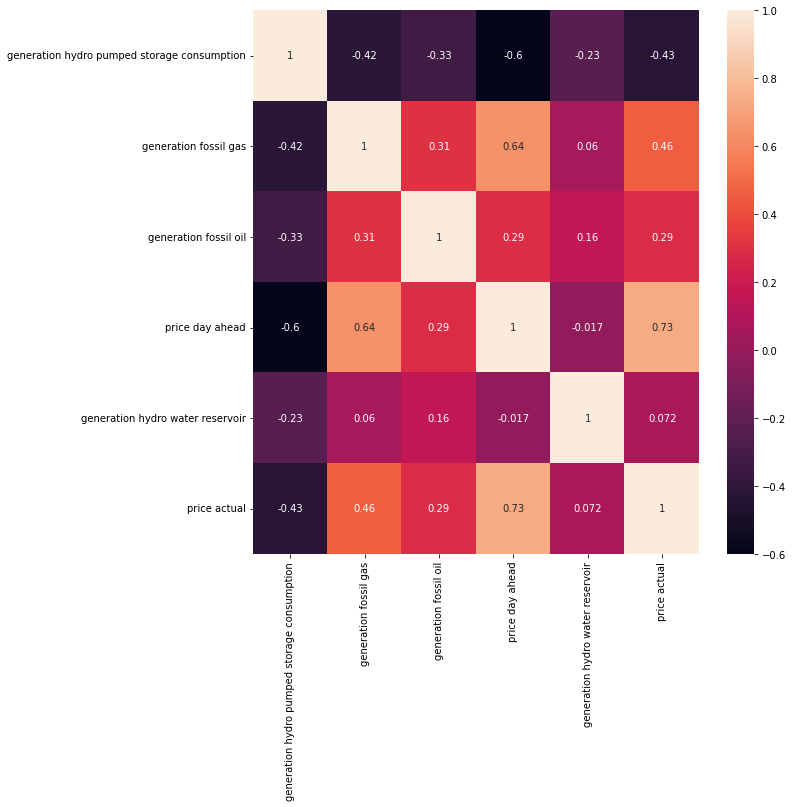

In [29]:
fig = plt.figure(figsize=(10, 10))
g = sns.heatmap(subsampleX[subsample].corr(), annot=True)

## Step 5: Choose a task formulation for regression. Estimate multivariate correlation (target-predictors).

In [30]:
subsampleX['y'] = target
subsampleX.pop('weather_main')
print(subsampleX.corr()['y'][:])

generation hydro pumped storage consumption   -0.562934
generation fossil gas                          0.548986
generation fossil oil                          0.496139
price day ahead                                0.474273
generation hydro water reservoir               0.479491
price actual                                   0.435253
y                                              1.000000
Name: y, dtype: float64


In [31]:
c = subsampleX.corr()['y'][:].values
subsampleX.pop('y')

0        25385.0
1        24382.0
2        22734.0
3        21286.0
4        20264.0
          ...   
35059    30653.0
35060    29735.0
35061    28071.0
35062    25801.0
35063    24455.0
Name: y, Length: 35064, dtype: float64

In [32]:
c = c[:6]
c

array([-0.56293421,  0.54898567,  0.4961387 ,  0.47427338,  0.47949102,
        0.43525273])

In [33]:
print(c.T.dot(np.linalg.inv(subsampleX.corr().values)).dot(c))

0.6338492295540824


## Step 6 & 7: Build regression model and make an analysis of multicollinearity and regularization (if needed). Analyze the quality of regression model (distribution of residuals, determination coefficient).

In [34]:
X_train, X_test, y_train, y_test = train_test_split(subsampleX[subsample], target, test_size=0.25, random_state=42)

In [35]:
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


In [36]:
print('R2 score: {}'.format(r2_score(y_test, y_pred)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

R2 score: 0.6326691051213178
MSE: 7644900.645578749
MAE: 2258.100701872319


In [37]:
ls = Lasso(alpha=0.1)
ls.fit(X_train, y_train)
y_pred = ls.predict(X_test)

In [38]:
print('R2 score: {}'.format(r2_score(y_test, y_pred)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

R2 score: 0.632669137287772
MSE: 7644899.976129623
MAE: 2258.100682265707


In [39]:
lsic = LassoLarsIC(criterion='aic')
lsic.fit(X_train, y_train)
y_pred = lsic.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


In [40]:
print('R2 score: {}'.format(r2_score(y_test, y_pred)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

R2 score: 0.6326691051213178
MSE: 7644900.645578749
MAE: 2258.100701872319


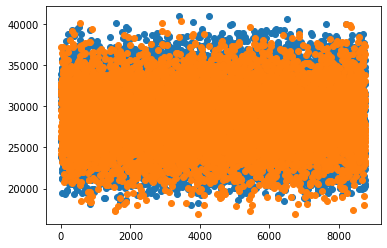

In [41]:
plt.scatter(list(range(len(y_test))), y_test, label='True')
plt.scatter(list(range(len(y_test))), lr.predict(X_test), label='Predict')

In [42]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3)
X_train_new = poly.fit_transform(X_train)
poly = PolynomialFeatures(3)
X_test_new = poly.fit_transform(X_test)

In [43]:
lrp = LinearRegression(normalize=True)
lrp.fit(X_train_new, y_train)
y_pred = lrp.predict(X_test_new)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


In [44]:
print('R2 score: {}'.format(r2_score(y_test, y_pred)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

R2 score: 0.6971762983597937
MSE: 6302375.17301764
MAE: 2001.8767985957682


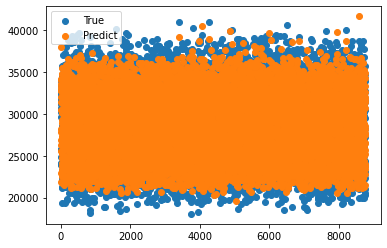

In [45]:
plt.scatter(list(range(len(y_test))), y_test, label='True')
plt.scatter(list(range(len(y_test))), lrp.predict(X_test_new), label='Predict')
plt.legend()

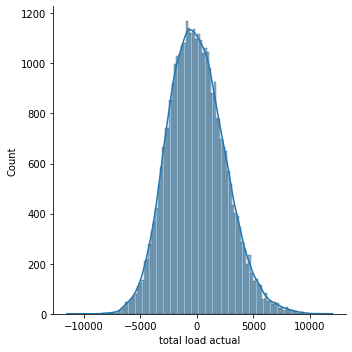

In [47]:
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(subsampleX[subsample])
sns.displot((target - lrp.predict(X_poly)), kde=True)

In [48]:
res = (target - lrp.predict(X_poly))

In [49]:
res.mean()

-14.92778787262189

In [50]:
res.std()

2511.475892688819

In [51]:
res

0        2597.451311
1        2207.335217
2        1043.981528
3        -491.098251
4       -1637.200376
            ...     
35059    1606.447089
35060    1014.305722
35061     360.347515
35062    -828.657916
35063   -1965.581009
Name: total load actual, Length: 35064, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


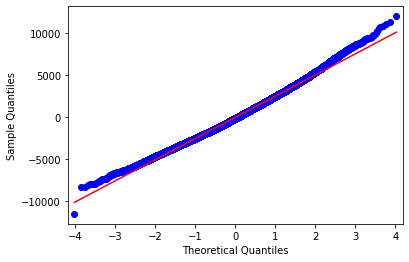

In [52]:
from statsmodels.graphics.gofplots import qqplot
qqplot(res, line='s')
plt.show()

In [53]:
params = stats.norm.fit(res)

In [54]:
ks = stats.kstest(res, 'norm', params)
ks

KstestResult(statistic=0.021115230859518996, pvalue=5.272797750947111e-14)

In [55]:
from scipy.stats import shapiro
stat, p = shapiro(res)
print(stat, p)
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

0.9952780604362488 3.255132641819656e-31
Sample does not look Gaussian (reject H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
